In [1]:
%matplotlib inline

import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
import math

from load_ops import plot,rescale,norm
from load_ops import compute_new_v
from load_ops import compute_forget_index
from load_ops import compute_hidden_states_relation
from load_ops import compute_forget_gate_relation
from load_ops import RMSE_compute
from load_ops import ND_compute

batch_size = 64
window_size = 192
encode_length = 168
decode_length = 24
hidden_unit = 10

shift_train_data = np.load("../data/fake_data/dataset_4/elect_pre_train_data.npy")
shift_train_onehot = np.load("../data/fake_data/dataset_4/elect_train_onehot.npy")
v_all = np.load("../data/fake_data/dataset_4/elect_train_v.npy")
shift_train_label = np.load("../data/fake_data/dataset_4/elect_train_label.npy")
param = np.load("../data/fake_data/dataset_4/elect_train_param.npy")
index_list = np.load("../data/fake_data/dataset_4/elect_train_index.npy")
indexs_pred_list = np.load("../data/fake_data/dataset_4/elect_train_pred_index.npy")

window_size = param[7]



/home/guest/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:

with tf.Session() as sess:
       
    #ckpt包含所有checkpoint信息和最新checkpoint信息
    checkpoint_dir = '../checkpoint/checkpoint_forget_Fake_no_monthly'
    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    print(ckpt)
    
    # ckpt.model_checkpoint_path是最新checkpoint的名字，加上".meta"即可用于导入graph
    if (ckpt and ckpt.model_checkpoint_path):
        #加载计算图
        saver = tf.train.import_meta_graph(ckpt.model_checkpoint_path+".meta")
        #加载参数
        saver.restore(sess, ckpt.model_checkpoint_path)
    else:
        print("No model can be load!")

    train_op = tf.get_collection('train_op')[0]
    label = tf.get_collection("label")[0]

    miu_train = tf.get_collection("miu_train")[0]
    sigma_train = tf.get_collection("sigma_train")[0]
    RMSE_train = tf.get_collection("RMSE_train")[0]
    ND_train = tf.get_collection("ND_train")[0]

    miu_pred = tf.get_collection("miu_pred")[0]
    sigma_pred = tf.get_collection("sigma_pred")[0]
    RMSE_pred = tf.get_collection("RMSE_pred")[0]
    ND_pred = tf.get_collection("ND_pred")[0]
    hidden_states_all = tf.get_collection("hidden_states_all")[0] # shape: [2, batch_size, hidden_unit, window_size] = [2, 64, 40, 192]
    forget_gate_all = tf.get_collection("CNN_output")[0] #shape: [batch_size, window_size=192, hidden_unit=40]


    def test_step(x_batch, onehot_batch, y_batch, v_batch, batch_size, keep_prob, forget_gate_mask):
        feed_dict ={
        'input_x:0': x_batch, 
        'input_onehot:0': onehot_batch,
        'input_y:0': y_batch,
        'input_v:0' :v_batch,
        'input_batch:0': batch_size,
        'keep_prob:0': keep_prob,
        "forget_gate_mask:0": forget_gate_mask,
        }
        RMSE_test, ND_test, miu_test, sigma_test, hidden_states_all_test, = sess.run([RMSE_pred,
                                                            ND_pred,
                                                            miu_pred,
                                                            sigma_pred,
                                                            hidden_states_all,                      
                                                            ], feed_dict = feed_dict)
           
        return (RMSE_test, ND_test, miu_test, sigma_test, hidden_states_all_test)
        
    
    #indexs_pred = [410688, 324890, 81043, 269732, 382203, 421931, 363429, 517402]
    #indexs_pred = [i+1058 for i in range(64)]
    #indexs_pred = [i*1375 for i in range(64)]
    #indexs_pred = [i+41992 for i in range(64)]
    print ("indexs_pred_list.shape: ", indexs_pred_list.shape)
    RMSE=0
    ND=0
    for i, index_pred in enumerate(indexs_pred_list):
        input_x_batch_pred = shift_train_data[index_pred]
        input_onehot_batch_pred =shift_train_onehot[index_pred]
        input_v_batch_pred = v_all[index_pred]
        input_y_batch_pred = shift_train_label[index_pred]
        input_y_batch_pred = np.asfarray(input_y_batch_pred, float)
        batch_size_pred = len(index_pred)
        forget_gate_mask_sample = np.full((64, 192, 40), 1, dtype = np.float32) #all 1

        RMSE_test, ND_test, miu_test, sigma_test, hidden_states_all_test = test_step(x_batch = input_x_batch_pred, 
                                                            onehot_batch = input_onehot_batch_pred, 
                                                            y_batch = input_y_batch_pred, 
                                                            v_batch = input_v_batch_pred, 
                                                            batch_size = batch_size_pred,
                                                            keep_prob = 1.0, 
                                                            forget_gate_mask = forget_gate_mask_sample, 
                                                            )
        
        RMSE_test = RMSE_compute(miu_test, input_y_batch_pred ,sigma_test, encode_length, decode_length, window_size)
        ND_test = ND_compute(i, miu_test, input_y_batch_pred ,sigma_test, encode_length, decode_length, window_size)
        RMSE += RMSE_test
        ND += ND_test
        
        #print (RMSE_test)
        #print (ND_test)
        #print ("***")
    RMSE /= indexs_pred_list.shape[0]
    ND /= indexs_pred_list.shape[0]
    print ("RMSE: ", RMSE)
    print ("ND: ", ND)



model_checkpoint_path: "../checkpoint/checkpoint_forget_Fake_no_monthly/DeepAR_model-62000"
all_model_checkpoint_paths: "../checkpoint/checkpoint_forget_Fake_no_monthly/DeepAR_model-60000"
all_model_checkpoint_paths: "../checkpoint/checkpoint_forget_Fake_no_monthly/DeepAR_model-60500"
all_model_checkpoint_paths: "../checkpoint/checkpoint_forget_Fake_no_monthly/DeepAR_model-61000"
all_model_checkpoint_paths: "../checkpoint/checkpoint_forget_Fake_no_monthly/DeepAR_model-61500"
all_model_checkpoint_paths: "../checkpoint/checkpoint_forget_Fake_no_monthly/DeepAR_model-62000"

INFO:tensorflow:Restoring parameters from ../checkpoint/checkpoint_forget_Fake_no_monthly/DeepAR_model-62000
hidden_states_all_test.shape:  (3, 2, 64, 40, 192)
hidden_states_c.shape:  (64, 192, 40)
************************************************************************************


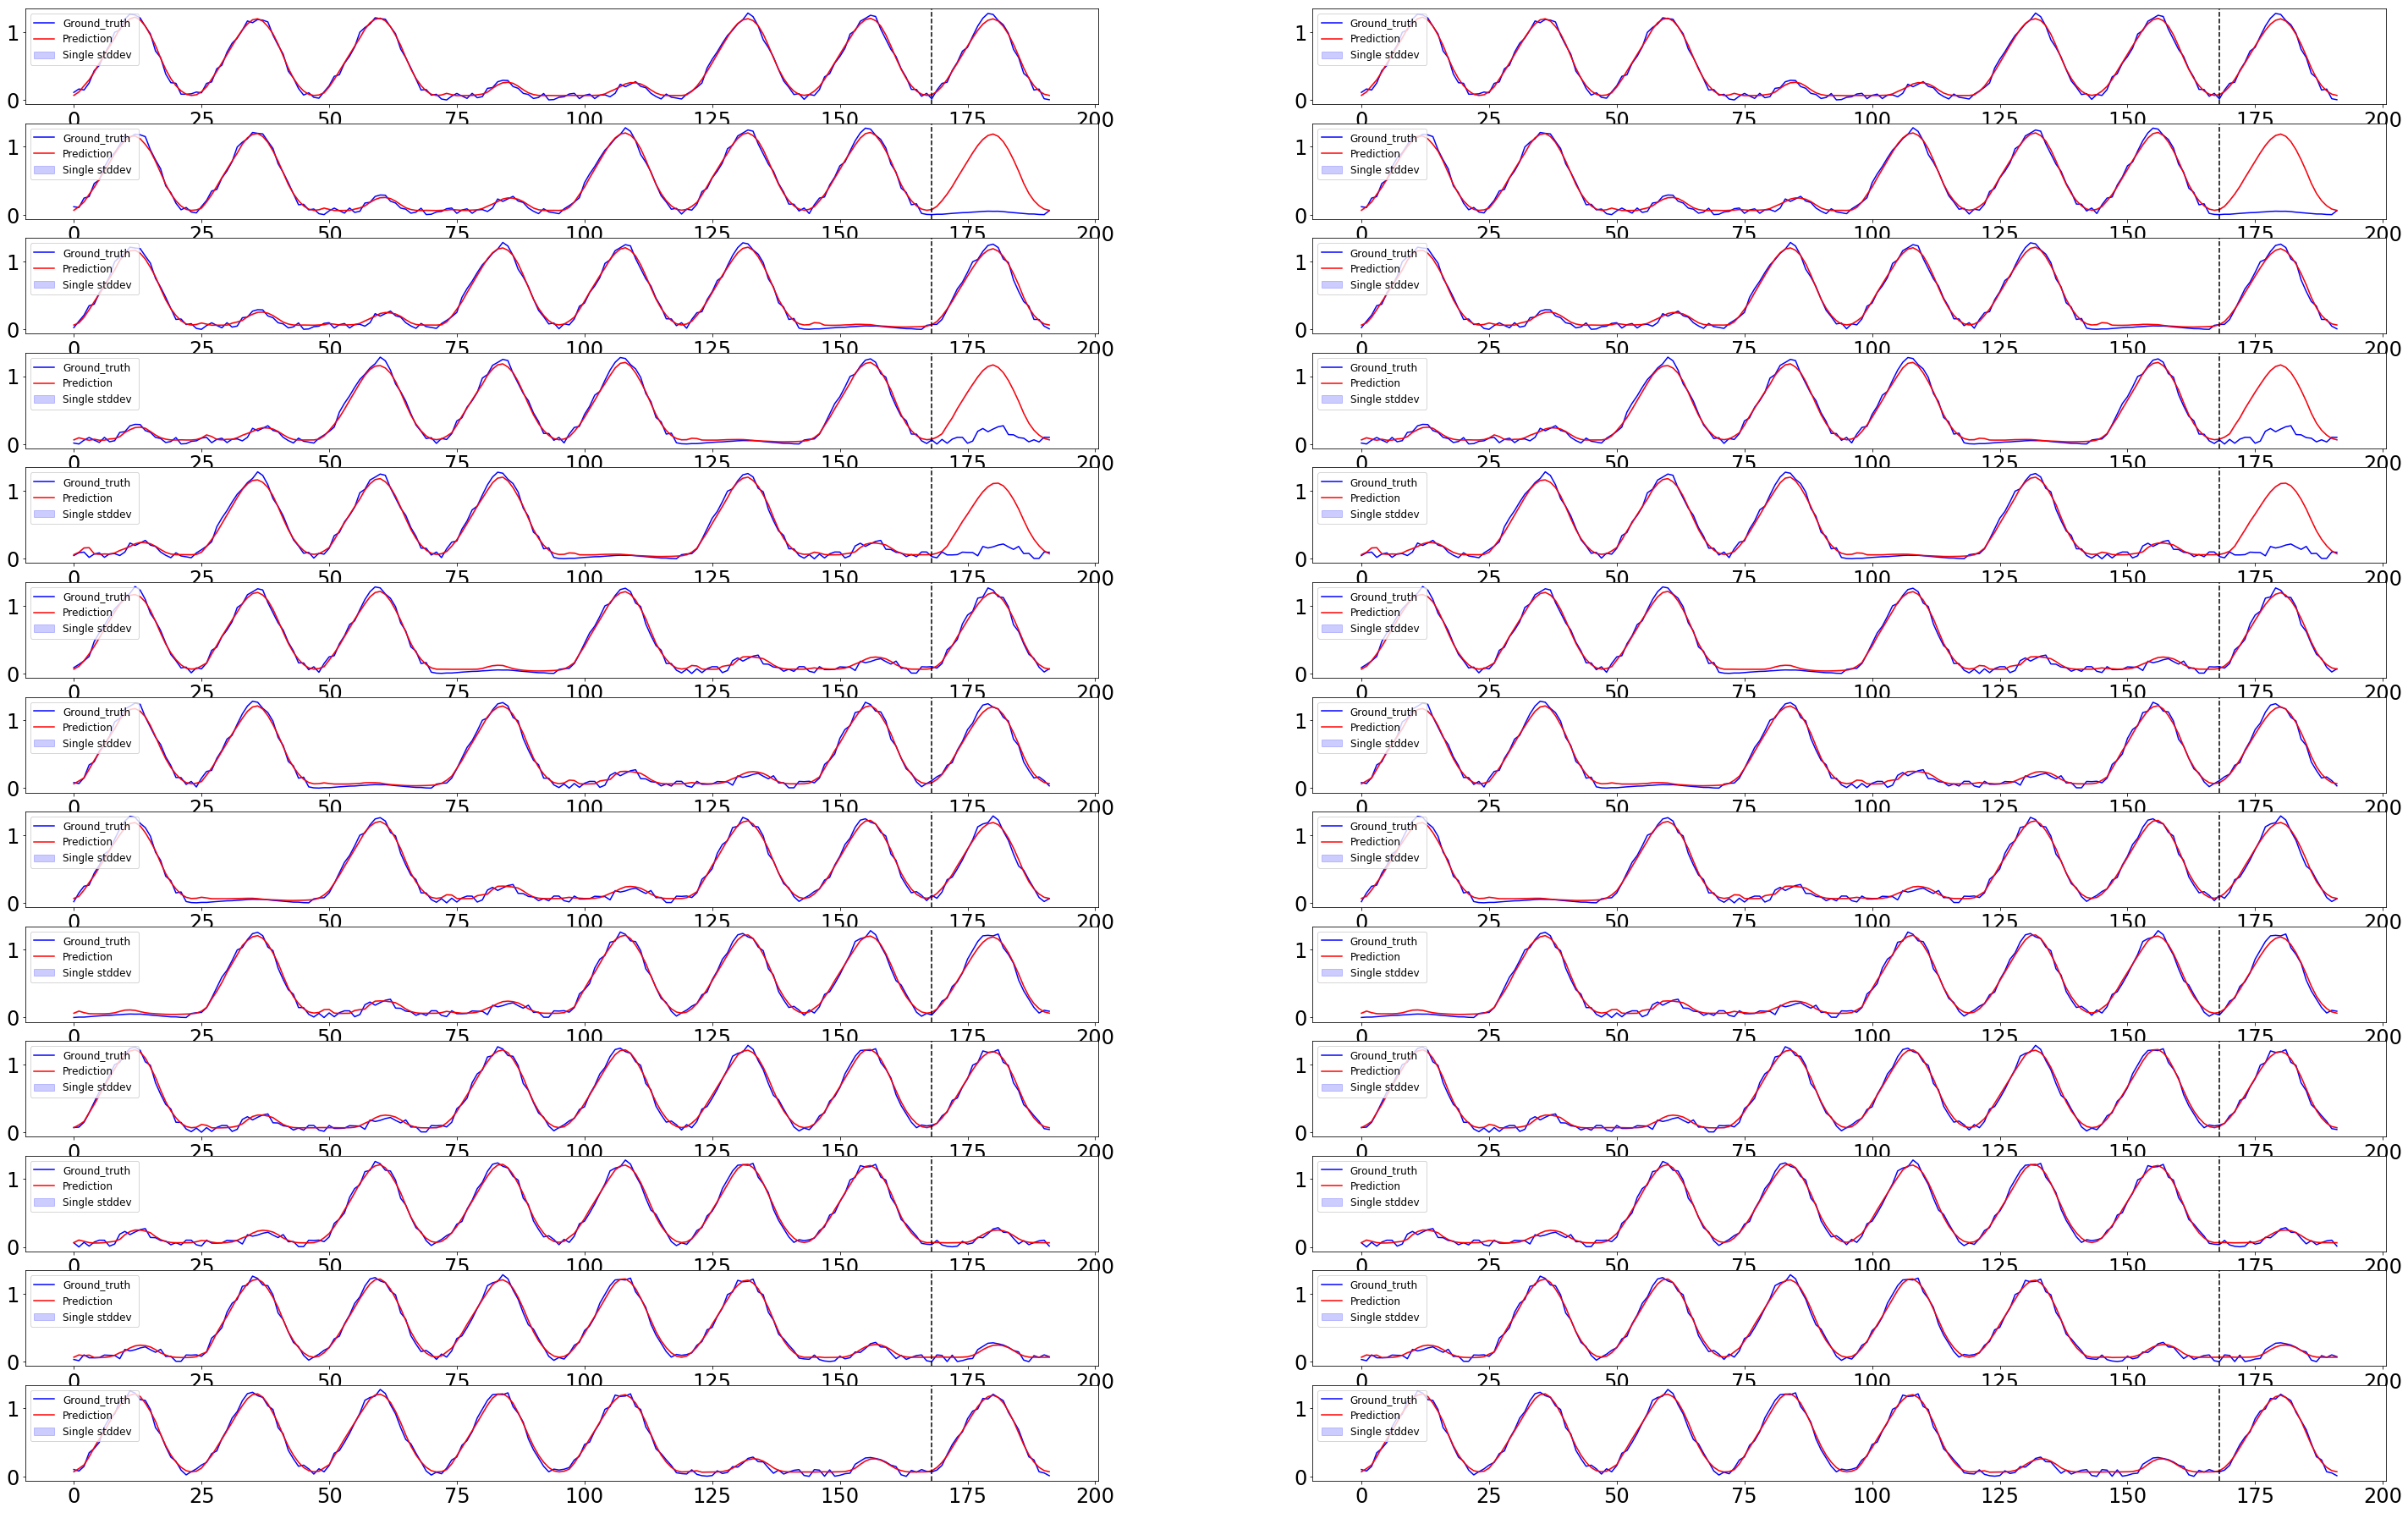

In [5]:
with tf.Session() as sess:

    checkpoint_dir = '../checkpoint/checkpoint_forget_Fake_no_monthly'
    
    #ckpt包含所有checkpoint信息和最新checkpoint信息
    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    print(ckpt)
    # ckpt.model_checkpoint_path是最新checkpoint的名字，加上".meta"即可用于导入graph
    if (ckpt and ckpt.model_checkpoint_path):
        #加载计算图
        saver = tf.train.import_meta_graph(ckpt.model_checkpoint_path+".meta")
        #加载参数
        saver.restore(sess, ckpt.model_checkpoint_path)


    else:
        print("No model can be load!")

    train_op = tf.get_collection('train_op')[0]
    label = tf.get_collection("label")[0]
    miu_train = tf.get_collection("miu_train")[0]
    sigma_train = tf.get_collection("sigma_train")[0]
    RMSE_train = tf.get_collection("RMSE_train")[0]
    ND_train = tf.get_collection("ND_train")[0]
    miu_pred = tf.get_collection("miu_pred")[0]
    sigma_pred = tf.get_collection("sigma_pred")[0]
    RMSE_pred = tf.get_collection("RMSE_pred")[0]
    ND_pred = tf.get_collection("ND_pred")[0]
    hidden_states_all = tf.get_collection("hidden_states_all")[0] # shape: [2, batch_size, hidden_unit, window_size] = [2, 64, 40, 192]


    def test_step(x_batch, onehot_batch, y_batch, v_batch, batch_size, keep_prob, forget_gate_mask):
        feed_dict ={
        'input_x:0': x_batch, 
        'input_onehot:0': onehot_batch,
        'input_y:0': y_batch,
        'input_v:0' :v_batch,
        #'input_mean:0':mean_batch,
        'input_batch:0': batch_size,
        'keep_prob:0': keep_prob,
        "forget_gate_mask:0": forget_gate_mask,
        }
        RMSE_test, ND_test, miu_test, sigma_test, hidden_states_all_test, = sess.run([RMSE_pred,
                                                            ND_pred,
                                                            miu_pred,
                                                            sigma_pred,
                                                            hidden_states_all,                      
                                                            ], feed_dict = feed_dict)
        

        
        return (RMSE_test, ND_test, miu_test, sigma_test, hidden_states_all_test)
        
    
    #indexs_pred = [410688, 324890, 81043, 269732, 382203, 421931, 363429, 517402]
    #indexs_pred = [i+1058 for i in range(64)]
    #indexs_pred = [i for i in range(64)]
    #indexs_pred = [i+41992 for i in range(64)]
    #indexs_pred = indexs_pred_list[0]
    #indexs_pred = [i+16442   for i in range(64)] # keep it
#   indexs_pred = [i+939    for i in range(64)] # keep it
    indexs_pred = [i+163488-8    for i in range(64)] # keep it

 
    input_x_batch_pred = shift_train_data[indexs_pred]
    input_onehot_batch_pred =shift_train_onehot
    input_v_batch_pred = v_all[indexs_pred]
    input_y_batch_pred = shift_train_label[indexs_pred]
    input_y_batch_pred = np.asfarray(input_y_batch_pred, float)
    batch_size_pred = len(indexs_pred)
    forget_gate_mask_sample = np.full((64, 192, 40), 1, dtype = np.float32) #all 1
    
    
    

    RMSE_test, ND_test, miu_test, sigma_test, hidden_states_all_test = test_step(x_batch = input_x_batch_pred, 
                                                        onehot_batch = input_onehot_batch_pred, 
                                                        y_batch = input_y_batch_pred, 
                                                        v_batch = input_v_batch_pred, 
                                                        batch_size = batch_size_pred,
                                                        keep_prob = 1.0, 
                                                        forget_gate_mask = forget_gate_mask_sample, 
                                                        )
    
    ### hidden states ### shape:  [3, 2, 64, 40, 192] or [2, 64, 40, 192]
    print ("hidden_states_all_test.shape: ", hidden_states_all_test.shape)
    if  len(hidden_states_all_test.shape) == 5:
        hidden_states_c = hidden_states_all_test[0, 0, :, :, :] 
    elif len(hidden_states_all_test.shape) == 4:
        hidden_states_c = hidden_states_all_test[0, :, :, :] 
    else:
        print ("hidden_states shape not compatible")
    hidden_states_c = np.swapaxes(hidden_states_c, -1, -2) # [batch_size, window_size, hidden_unit]
    print ("hidden_states_c.shape: ", hidden_states_c.shape)
    hidden_states_dot = []
    #forget_gate_dot = []
    for serie in range(batch_size):
        hidden_states_dot_serie = []
        #forget_gate_dot_serie = []
        for i in range(window_size):
            hidden_states_dot_temp = compute_hidden_states_relation(hidden_states_c[serie, :, :], i, window_size)
            hidden_states_dot_serie.append(hidden_states_dot_temp)
            #forget_gate_dot_temp = compute_forget_gate_relation(forget_gate_all_test[serie, :, :], i, window_size)
            #forget_gate_dot_serie.append(forget_gate_dot_temp)
        hidden_states_dot.append(hidden_states_dot_serie)
        #forget_gate_dot.append(forget_gate_dot_serie)
    hidden_states_dot = np.array(hidden_states_dot)#[64, 192]
    hidden_states_dot = norm(hidden_states_dot)
    #forget_gate_dot = np.array(forget_gate_dot)
    #forget_gate_dot = norm(forget_gate_dot)
    print ("************************************************************************************")
    
    input_y_batch_pred_copy = np.copy(input_y_batch_pred)
    miu_test_copy = miu_test
    sigma_test_copy = sigma_test
    
    ## WITH FORGET
    # rescale values after the last change point
    '''
    forget_index = compute_forget_index(input_pvalue_batch_pred) #[64,]
    new_v = []
    for serie in range(64):
        if forget_index[serie] != -1:
            index_temp = forget_index[serie]
            input_x_batch_pred_new = input_x_batch_pred[serie, index_temp+1:, 0] 
            #print (input_x_batch_pred_new.shape) #[length_after_change,]
            input_v_new = compute_new_v(input_x_batch_pred_new*input_v_batch_pred[serie])
            new_v.append(input_v_new)
            input_x_batch_pred_new = rescale(input_x_batch_pred_new, 
                                             v_old=input_v_batch_pred[serie], 
                                             v_new=input_v_new, )
            input_x_batch_pred[serie, index_temp+1:, 0] = input_x_batch_pred_new
        else:
            new_v.append(input_v_batch_pred[serie])   
    #print (new_v)
    #print (input_v_batch_pred)
    new_v = np.array(new_v)
    new_v = np.expand_dims(new_v, axis=1) #[batch_size, 1]
    '''
    
    
    RMSE_test_f, ND_test_f, miu_test_f, sigma_test_f, hidden_states_all_test_f  = test_step(x_batch = input_x_batch_pred, 
                                                        onehot_batch = input_onehot_batch_pred, 
                                                        y_batch = input_y_batch_pred, 
                                                        v_batch = input_v_batch_pred, 
                                                        batch_size = batch_size_pred,
                                                        keep_prob = 1.0,                                                                                            
                                                        forget_gate_mask = forget_gate_mask_sample, 
                                                        )
    
    #miu_test_f  = np.true_divide(miu_test_f, new_v)
    #sigma_test_f  = np.true_divide(sigma_test_f, np.sqrt(new_v))
    #forget_gate_all_test_f = mean(forget_gate_all_test_f, axis=2) #[batch_size, window_length]
  
    plot(label = input_y_batch_pred, 
             label_f = input_y_batch_pred_copy,
             prediction = miu_test,
             sigma_test = sigma_test,
             prediction_f =miu_test_f , 
             sigma_test_f = sigma_test_f, 
             window_size = 192, 
             num_plot = 26,
             #y_range = [-2, 5],
             #y_range_f = [-2, 60],
             #forget_gate = forget_gate_dot, 
             #forget_gate_f=forget_gate_dot,
             save_num = None,
             #save_num = 'DeepAR',
                )

